# Finalized Data Preprocessing and Model Creation

In [55]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\mboyk\miniconda3\python.exe -m pip install --upgrade pip


## Data Preprocessing

In [3]:
# for data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import yfinance as yf
from sklearn import linear_model
# Split later
from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from keras.optimizers import SGD

/Users/harshgurnani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[*********************100%%**********************]  1 of 1 completed


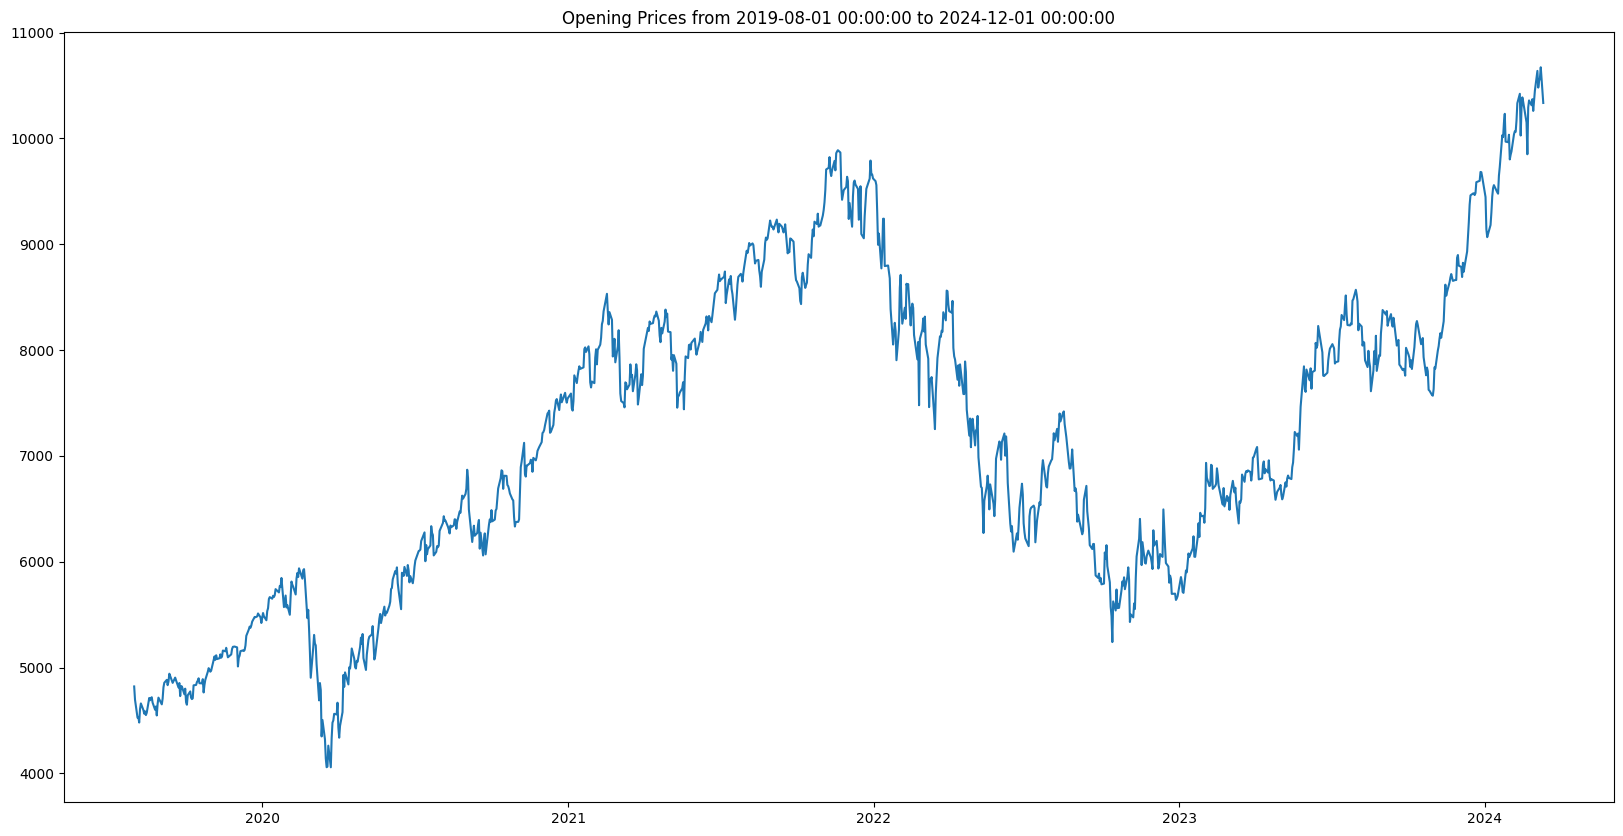

In [4]:
# initialize parameters 
start_date = datetime(2019, 8, 1)
end_date = datetime(2024, 12, 1)

# get the data 
stock_data = yf.download('^NDXT', start = start_date,
                         end = end_date)

stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8') # False: not include index

# display 
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(stock_data['Open'])
plt.show()

In [5]:
def date_to_index(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    for i in range(len(date_col_stock_data)):
        if date_col_stock_data[i] == date:
            return i
    return -1

def get_closest_available_date(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    # date_col_stock_data = stock_data.reset_index()['Date']
    while date not in date_col_stock_data:
        date = date - timedelta(days = 1)
    return date

"""
@param stock_data: original stock_data df
@param week_end: layoff date
@param period: number of days to look back, defaults to 7

@return % of change in NDXT index price during last week before layoff date 
"""
def weekly_price_diff(stock_data, week_end, period: int = 7):
    # week end date in format datetime(YYYY,MM,DD)

    if (week_end < datetime(2020, 1, 15)):
        return 0
    date_col_stock_data = stock_data.reset_index() # add DATE as column
    date_end_closest = get_closest_available_date(stock_data, week_end)
    date_start_closest = get_closest_available_date(stock_data, week_end - timedelta(days = period))

    price_end = stock_data['Open'][date_end_closest]
    price_start = stock_data['Open'][date_start_closest]
    price_diff = (price_end - price_start) / price_start * 100

    return price_diff # in PERCENTAGE

# ! USAGE EXAMPLE
price_diff = weekly_price_diff(stock_data, datetime(2022, 4, 11))
price_diff = round(price_diff, 2)
print(f"Diff between 11 APR 2022 and week before: {price_diff}%")

Diff between 11 APR 2022 and week before: -7.59%


In [6]:
# TODO: ADD RETRIEVED STOCK CHANGE TO DATA_PD

week_price_diff_df = pd.DataFrame(index = stock_data.index, columns = ['price_diff'])
for date in week_price_diff_df.index:
    week_price_diff_df.loc[date, 'price_diff'] = weekly_price_diff(stock_data, date)

stock_data['price_diff'] = week_price_diff_df['price_diff']
stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8')
stock_data

,Open,High,Low,Close,Adj Close,Volume,price_diff
Date,,,,,,,
2019-08-01,4821.149902,4924.919922,4726.339844,4762.810059,4762.810059,425800,0
2019-08-02,4695.549805,4712.990234,4629.250000,4655.560059,4655.560059,356000,0
2019-08-05,4525.939941,4534.649902,4434.459961,4469.970215,4469.970215,427900,0
2019-08-06,4530.689941,4562.890137,4481.229980,4531.810059,4531.810059,317500,0
2019-08-07,4480.180176,4563.459961,4470.759766,4550.560059,4550.560059,321600,0
...,...,...,...,...,...,...,...
2024-03-05,10480.400391,10489.519531,10255.240234,10332.759766,10332.759766,0,1.055839
2024-03-06,10542.009766,10566.629883,10407.910156,10475.540039,10475.540039,0,2.747636
2024-03-07,10568.570312,10719.269531,10530.219727,10686.650391,10686.650391,0,2.08901


In [26]:
def str_to_datetime(dt_string):
    return datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S UTC")

layoff_data = pd.read_csv("tech_layoffs.csv")

layoff_data["Date_layoffs"] = layoff_data["Date_layoffs"].apply(lambda x: str_to_datetime(x))
layoff_data['Company'] = layoff_data['Company'].replace({'SaleSan Franciscoorce': 'Salesforce'})
layoff_data.set_index('Date_layoffs', inplace = True)
layoff_data = layoff_data.sort_index()
layoff_data = layoff_data[layoff_data['Continent'] == 'North America']
layoff_data = layoff_data[layoff_data['Country'] == 'USA']
layoff_data = layoff_data[layoff_data['Company_Size_before_Layoffs'] >= 10]
layoff_data = layoff_data.drop(columns=["Company", "lat", "lng", "Continent", "Country", "#"])

cities_by_timezone = {
    'Pacific Time': ['Los Angeles', 'San Francisco Bay Area', 'Seattle', 'Portland', 'San Luis Obispo', 'Sacramento', 'San Diego', 'Santa Barbara', 'Camarillo', 'Fremont', 'Bend', 'Reno', 'Spokane', 'Las Vegas', 'Fresno'],
    'Mountain Time': ['Denver', 'Boulder', 'Salt Lake City', 'Missoula', 'Santa Fe', 'Phoenix', 'Lehi', 'Logan', 'Boise'],
    'Central Time': ['Austin', 'Chicago', 'Minneapolis', 'Milwaukee', 'Nashville', 'Dallas', 'Cincinnati', 'Columbus', 'Indianapolis', 'Nebraska City', 'Kansas City'],
    'Eastern Time': ['New York City', 'Boston', 'Atlanta', 'Ann Arbor', 'Miami', 'Detroit', 'Stamford', 'Washington DC', 'Philadelphia', 'Raleigh', 'Walnut', 'Madison', 'Dover', 'Burlington', 'Wilmington', 'Nashua', 'Baltimore', 'Tampa Bay']
}

def get_timezone(city):
    for timezone, cities in cities_by_timezone.items():
        if city in cities:
            return timezone
    return None

# Assign new attribute 'Timezone' based on city
layoff_data['Region'] = layoff_data['Location_HQ'].map(get_timezone)
layoff_data = layoff_data.drop(columns=["Location_HQ", "Company_Size_after_layoffs", "Laid_Off"]) 

#Incorporate stock price
layoff_data = layoff_data.reset_index()

#Create a new column for stock price change, and add it to the layoff_data_with_date_col dataframe
layoff_data.insert(1, "stock_delta", layoff_data["Date_layoffs"].apply(lambda x: weekly_price_diff(stock_data, x, period=90)))
layoff_data  # bug: several stock_delta values are 0, which is highly improbable.


industry_encoder = LabelEncoder()
layoff_data['industry_encoded'] = industry_encoder.fit_transform(layoff_data['Industry'])

time_encoder = LabelEncoder()
layoff_data['Region_encoded'] = time_encoder.fit_transform(layoff_data['Region'])

# Create LabelEncoder instance for stage column
stage_encoder = LabelEncoder()
layoff_data['stage_encoded'] = stage_encoder.fit_transform(layoff_data['Stage'])
layoff_data = layoff_data.drop(columns=["Industry", "Stage","Year","Region"])
layoff_data['Money_Raised_in_$_mil'] = layoff_data['Money_Raised_in_$_mil'].str.replace('$', '').astype(float) * 1000000

#convert date layoffs to unix
layoff_data['Date_layoffs'] = layoff_data['Date_layoffs'].apply(lambda x: int(datetime.timestamp(x)))


Y = layoff_data['Percentage']

# layoff_data = layoff_data.drop(columns=["Date_layoffs"])

industry = layoff_data['industry_encoded']
stage = layoff_data['stage_encoded'] 
region = layoff_data['Region_encoded']

# Reshape to a 2D array
industry = industry.values.reshape(-1, 1)
stage = stage.values.reshape(-1, 1)
region = region.values.reshape(-1, 1)

# #display
# display(layoff_data)


# One-hot encode
encoder = OneHotEncoder(sparse_output=False, drop='first')
industry_onehot = encoder.fit_transform(industry)
encoder = OneHotEncoder(sparse_output=False, drop='first')
stage_onehot = encoder.fit_transform(stage)
encoder = OneHotEncoder(sparse_output=False, drop='first')
region_onehot = encoder.fit_transform(region)

# Display the one-hot encoded arrays

# Drop the original categorical columns from layoff_data
layoff_data = layoff_data.drop(columns=["industry_encoded", "stage_encoded", "Region_encoded"])
layoff_data = layoff_data.drop(columns=["Percentage"])
display(layoff_data)

# Concatenate numerical features and one-hot encoded features
data_array = np.hstack((layoff_data.values, industry_onehot, stage_onehot, region_onehot))

X = data_array

print(X.shape)
print(Y.shape)

,Date_layoffs,stock_delta,Company_Size_before_Layoffs,Money_Raised_in_$_mil
0,1583996400,-17.938421,50,90000000.0
1,1584082800,-15.003683,80,45000000.0
2,1584342000,-19.758224,591,79000000.0
3,1584342000,-19.758224,16,6000000.0
4,1584514800,-24.824380,20,4000000.0
...,...,...,...,...
897,1704873600,14.204551,188000,26000000.0
898,1704873600,14.204551,450,57000000.0
899,1704960000,15.684460,1000,995000000.0
900,1704960000,15.684460,2000,14000000.0


(902, 51)
(902,)


In [8]:
print(X.shape)
print(Y.shape)

(902, 51)
(902,)


In [39]:
layoff_data = pd.read_csv("tech_layoffs.csv")
layoff_data

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20 00:00:00 UTC,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19 00:00:00 UTC,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18 00:00:00 UTC,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18 00:00:00 UTC,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14 00:00:00 UTC,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,3286,Pitch,Berlin,Germany,Europe,80,2024-01-08 00:00:00 UTC,67.0,119,39,Other,Series B,$138,2024,52.52437,13.41053
1414,3287,BenchSci,Toronto,Canada,North America,70,2024-01-08 00:00:00 UTC,17.0,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864
1415,3288,NanoString Technology,Seattle,USA,North America,50,2024-01-08 00:00:00 UTC,9.0,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207
1416,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-01-04 00:00:00 UTC,15.0,200,170,Retail,Series C,$199,2024,32.08088,34.78057


In [45]:
len(industry_encoder.classes_)

30

In [44]:
len(time_encoder.classes_)

5

In [43]:
len(stage_encoder.classes_)

15

In [33]:
industry

array([[24],
       [28],
       [29],
       [27],
       [18],
       [29],
       [ 9],
       [ 5],
       [29],
       [24],
       [22],
       [22],
       [23],
       [ 8],
       [22],
       [10],
       [29],
       [29],
       [29],
       [21],
       [ 6],
       [19],
       [18],
       [24],
       [14],
       [24],
       [20],
       [22],
       [28],
       [22],
       [ 5],
       [28],
       [28],
       [10],
       [23],
       [22],
       [18],
       [23],
       [ 3],
       [ 7],
       [19],
       [22],
       [10],
       [ 8],
       [18],
       [ 9],
       [16],
       [28],
       [ 3],
       [18],
       [16],
       [13],
       [18],
       [ 8],
       [18],
       [18],
       [13],
       [23],
       [22],
       [ 9],
       [ 2],
       [ 9],
       [24],
       [10],
       [11],
       [23],
       [11],
       [14],
       [18],
       [ 6],
       [24],
       [18],
       [16],
       [24],
       [ 8],
       [14],
       [19],

In [9]:
# Assuming you have already defined X and Y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set shapes: X_train =", X_train.shape, ", Y_train =", y_train.shape)
print("Testing set shapes: X_test =", X_test.shape, ", Y_test =", y_test.shape)

Training set shapes: X_train = (721, 51) , Y_train = (721,)
Testing set shapes: X_test = (181, 51) , Y_test = (181,)


In [10]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS: " + str(layoff_data.values[0]))
print("INDUSTRY ONEHOT: " + str(industry_onehot[0]))
print("STAGE ONEHOT: " + str(stage_onehot[0]))
print("REGION ONEHOT: " + str(region_onehot[0]))

print("X: " + str(X[0]))


LAYOFF DATA VALS: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.000

In [11]:
Y

0       40.000000
1       10.000000
2       22.000000
3      100.000000
4       20.000000
          ...    
897      0.531915
898     13.333333
899     17.000000
900      5.000000
901     13.000000
Name: Percentage, Length: 902, dtype: float64

# Model 1: Polynomial Regression

In our first model, we wanted to determine if a polynomial regression model
would work in predicting the percentage of employees that would be laid off.

In [65]:
mse_arr = []

In [66]:
logreg = LinearRegression()

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_df = pd.DataFrame(X_train_np)
y_train_df = pd.DataFrame(y_train_np)

logreg.fit(X_train_df, y_train_df)

yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

MSE_train = np.mean((y_train.values - yhat_train)**2)
MSE_test = np.mean((y_test.values - yhat_test)**2)

mse_arr.append((MSE_train, MSE_test))

print(f"MSE_train: {MSE_train}")
print(f"MSE_test: {MSE_test}")


MSE_train: 484.89271442931323
MSE_test: 409.1260231141291


In [67]:
for k in range(2,5):
    # Create kth degree polynomial
    poly = PolynomialFeatures(k)

    # Convert features to fit polynomial model
    train_features = poly.fit_transform(X_train_df)
    test_features = poly.fit_transform(X_test)

    # Create polynomial regression
    polyreg = LinearRegression()
    polyreg.fit(train_features, y_train_df)

    # Get predictions
    yhat_train = polyreg.predict(train_features)
    yhat_test = polyreg.predict(test_features)

    # Print resulting MSE
    MSE_train = np.mean((y_train.values - yhat_train) ** 2)
    MSE_test = np.mean((y_test.values - yhat_test) ** 2)

    mse_arr.append((MSE_train, MSE_test))

    print(f'Degree: {k}')
    print(f'    MSE_train: {MSE_train}')
    print(f'    MSE_test:  {MSE_test}')

Degree: 2
    MSE_train: 518.5206435359247
    MSE_test:  667.1790187299712
Degree: 3
    MSE_train: 531.3218609748809
    MSE_test:  624.8022476614655
Degree: 4
    MSE_train: 455.38698286324484
    MSE_test:  880.0471714897942


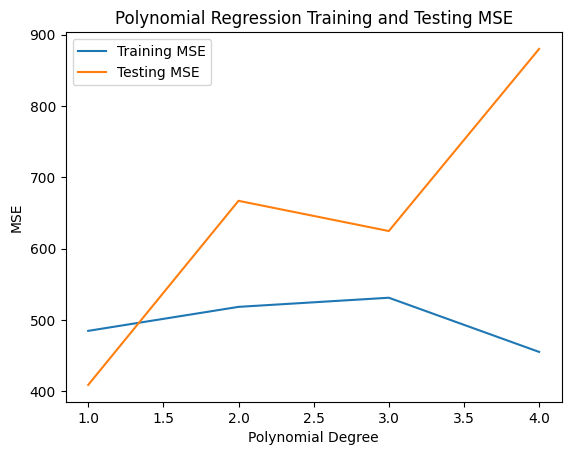

In [68]:
mse_train = [pair[0] for pair in mse_arr]
mse_test = [pair[1] for pair in mse_arr]

degrees = range(1, len(mse_arr) + 1)

plt.plot(degrees, mse_train, label='Training MSE')
plt.plot(degrees, mse_test, label='Testing MSE')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Polynomial Regression Training and Testing MSE')
plt.legend()

plt.show()

### Model 1 Analysis

From our fitting graph, we can conclude from our high MSE that our model is
underfitting regardless of the degree of our polynomial.

For our next two models, we are considering Automatic Relevance Determination
regression and a Neural Network. With ARD regression, we want to see if a
different regularization technique will better assign weights depending on the
feature in our modeling process. Meanwhile, a Neural Network may be better
suited in finding patterns within our data.

### Model 1 Conclusion

From our first model, we can conclude that polynomial regression might not be
the best model to use given our data. The high training and testing MSE along
with the long training times. It is possible that higher polynomial degrees or
isolating some of our input features may improve the performance of our model.
However, we would still run into issues where the polynomial regression takes
a long time to fit with our training data. Thus, we are less likely to use
this in our data.

In [69]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS: " + str(layoff_data.values[0]))
print("INDUSTRY ONEHOT: " + str(industry_onehot[0]))
print("STAGE ONEHOT: " + str(stage_onehot[0]))
print("REGION ONEHOT: " + str(region_onehot[0]))

print("X: " + str(X[0]))


LAYOFF DATA VALS: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.000

In [70]:
Y

0       40.000000
1       10.000000
2       22.000000
3      100.000000
4       20.000000
          ...    
897      0.531915
898     13.333333
899     17.000000
900      5.000000
901     13.000000
Name: Percentage, Length: 902, dtype: float64

# Model 2: Neural Network

In [71]:
"# Building model, splitting data, fitting model, and predicting points\n",
def build_nn():
    model = Sequential([
        Dense(12, activation='sigmoid', input_dim=51),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=SGD(learning_rate=0.1), loss='mse', metrics=['mse'])
    return model

classifier = KerasRegressor(model=build_nn, epochs=100, batch_size=5, verbose=0)
hist = classifier.fit(X_train, y_train)
predictions_test = classifier.predict(X_test)
predictions_train = classifier.predict(X_train)
print('Testing Mean Squared Error:', mean_squared_error(predictions_test, y_test))
print('Training Mean Squared Error:', mean_squared_error(predictions_train, y_train))

Testing Mean Squared Error: 584.9784896957286
Training Mean Squared Error: 786.0688282061325


In [78]:
import keras_tuner

In [79]:
import sklearn
import tensorflow as tf
from keras.optimizers import SGD

def buildHPmodel(hp):
  model= Sequential([
      Dense(12, activation = 'sigmoid', input_dim = 51),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=1,activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
])
  learning_rate = hp.Float("lr", min_value=0.05, max_value=0.3, sampling="log")
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
  return model

In [99]:
tuner = keras_tuner.GridSearch(
    hypermodel=buildHPmodel,
    objective="val_loss",
    directory="tunerStore",
    project_name="tunerInstance4",
    max_trials=50,
    seed=12,
    executions_per_trial=2,
    tune_new_entries=True,
    allow_new_entries=True,
    max_consecutive_failed_trials=3
)

In [100]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)

#load from tunerStore trial 48
import keras
# tuner = keras.models.load_model('tunerStore/tunerInstance3')
#why isnt this working? model = keras.models.load_model('tunerStore/tunerInstance3')


"""TO RUN A NEW GRID SEARCH UNCOMMENT THE LINE BELOW"""
tuner.search(X_train_np, y_train_np, epochs=10, validation_data=(X_val_np, y_val_np), batch_size=15)
# tuner.save('tunerStore/tunerInstance3')

Trial 50 Complete [00h 00m 08s]
val_loss: 402.2618942260742

Best val_loss So Far: 229.6578369140625
Total elapsed time: 00h 17m 27s


In [101]:
tuner.results_summary()

Results summary
Results in tunerStore\tunerInstance4
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 18 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.19168293127388178
Score: 229.6578369140625

Trial 47 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.07825422900366437
Score: 232.19811248779297

Trial 46 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.0936101501762388
Score: 400.6758041381836

Trial 49 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.13395323057981742
Score: 402.2618942260742

Trial 19 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.22929710267708991
Score: 406.30694580078125

Trial 14 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.07825422900366437
Score: 407.2531509399414

Trial 13 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.0936101501762388
Score: 407.33924865722656

Trial 44 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.05
Score: 407.4636001586914

Trial 16 summary
Hyperparamet

In [102]:
models = tuner.get_best_models(num_models=1)
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                624       
                                                                 
 dense_1 (Dense)             (None, 3)                 39        
                                                                 
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 691 (2.70 KB)
Trainable params: 691 (2.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
print("For our best model: \n")
print("The MSE for the training data: ", mean_squared_error(y_train, models[0].predict(X_train)))
print("The MSE for the testing data: ", mean_squared_error(y_test, models[0].predict(X_test)))
print("The MSE for the validation data: ", mean_squared_error(y_val, models[0].predict(X_val)))

For our best model: 

20/20 [==============================] - 0s 1ms/step
The MSE for the training data:  407.6795840293022
5/5 [==============================] - 0s 2ms/step
The MSE for the testing data:  344.07788384916205
5/5 [==============================] - 0s 2ms/step
The MSE for the validation data:  222.8351758414751


## Results from Grid Search
Trial 18 rendered the best predictions, with an MSE of 229.658, with Trial 47 and 46 coming in second and third respectively.

```Results in tunerStore\tunerInstance4
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 18 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.19168293127388178
Score: 229.6578369140625

Trial 47 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.07825422900366437
Score: 232.19811248779297

Trial 46 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.0936101501762388
Score: 400.6758041381836
...
units1: 3
acttype: relu
lr: 0.2742923480285484
Score: 412.06812286376953

```

## Overfitting/Underfitting
Based on the results of the best model's MSE: the MSE for the training data:  407.6795840293022, the MSE for the testing data:  344.07788384916205, and the MSE for the validation data:  222.8351758414751. We can conclude that the model is not overfitting since the MSE for the training data is not lower than the testing data.

In [80]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.metrics import MeanSquaredError
import numpy as np
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score

# Define the KFold parameters
kfold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

# Lists to store metrics for each fold
mse_per_fold_training = []
mse_per_fold_test = []

y_train_np = y_train.values
y_test_np = y_test.values

j = 0

# KFold Cross Validation
for train, test in kfold.split(X_train, y_train_np):
    # Create and compile the model
    model = build_nn()

    # Fit the model
    estimator = KerasRegressor(model=build_nn, epochs=50, batch_size=5, verbose=0)
    results = estimator.fit(X_train[train], y_train_np[train])

    # Predict and calculate MSE
    predictions_train = results.predict(X_train[train])
    predictions_test = results.predict(X_train[test])

    mse_train = mean_squared_error(y_train_np[train], predictions_train)
    mse_test = mean_squared_error(y_train_np[test], predictions_test)

    # Print metrics for this fold
    # print(f"Fold Accuracy: {acc*100:.2f}%")
    print(f"Fold {j+1} MSE for training: {mse_train:.4f}")
    print(f"Fold {j+1} MSE for testing: {mse_test:.4f}")


    # Append to the lists
    # acc_per_fold.append(acc * 100)
    mse_per_fold_test.append(mse_test)
    mse_per_fold_training.append(mse_train)
    j += 1


# Calculate and print average metrics
print(f"Average MSE for training: {np.mean(mse_per_fold_training):.4f}")
print(f"Average MSE for training: {np.mean(mse_per_fold_test):.4f}")

Fold 1 MSE for training: 800.3483
Fold 1 MSE for testing: 659.3152
Fold 2 MSE for training: 781.0257
Fold 2 MSE for testing: 831.5279
Fold 3 MSE for training: 780.2587
Fold 3 MSE for testing: 838.4422
Fold 4 MSE for training: 757.5928
Fold 4 MSE for testing: 1042.7502
Fold 5 MSE for training: 766.5234
Fold 5 MSE for testing: 962.2502
Fold 6 MSE for training: 759.6024
Fold 6 MSE for testing: 1024.6353
Fold 7 MSE for training: 793.1397
Fold 7 MSE for testing: 722.3335
Fold 8 MSE for training: 801.9471
Fold 8 MSE for testing: 642.9446
Fold 9 MSE for training: 809.1474
Fold 9 MSE for testing: 578.0418
Fold 10 MSE for training: 811.1258
Fold 10 MSE for testing: 560.2088
Average MSE for training: 786.0711
Average MSE for training: 786.2450


## Results from Cross Validation
Based on the training and testing MSE of the original model, the Testing Mean Squared Error was 584.9784896957286 and the Training Mean Squared Error was 786.0688282061325. This indicates that the model is not overfitting so the cross validation results do not benefit the model. Since cross validation is primarily helpful when a model is overfitting, cross validation does not benefit the model.


# Random Forest Regression

In [1]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
rf = RandomForestRegressor(random_state = 42, max_depth = 10, min_samples_split=10)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=42)

In [13]:
rf_predictions_test = rf.predict(X_test)
rf_predictions_train = rf.predict(X_train)

In [14]:
rf_mse_test = mean_squared_error(rf_predictions_test, y_test)
rf_mse_train = mean_squared_error(rf_predictions_train, y_train)

In [16]:
print(rf_mse_test, rf_mse_train)

267.5180215681688 129.86997059798847


In [17]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split
               }

In [18]:
# grid search!

bestMSE = None
bestEstimator = 0
bestDepth = 0
bestSamples = 0
mses = []

for estimator in n_estimators:
    temp1 = []
    for depth in max_depth:
        temp2 = []
        for samples_split in min_samples_split:
            rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth, min_samples_split=samples_split, random_state = 42)
            rf.fit(X_train, y_train)
            predictions_test = rf.predict(X_test)
            mse_test = mean_squared_error(predictions_test, y_test)
            temp2.append(mse_test)
            if bestMSE is None or mse_test < bestMSE:
                bestMSE = mse_test
                bestEstimator = estimator
                bestDepth = depth
                bestSamples = samples_split
        temp1.append(temp2)
    mses.append(temp1)


In [66]:
bestMSE, bestEstimator, bestDepth, bestSamples

(258.9582698038227, 133, 20, 2)

In [62]:
best_rf = RandomForestRegressor(random_state = 42, max_depth = bestDepth, min_samples_split=bestSamples, n_estimators=bestEstimator)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=133, random_state=42)

In [63]:
best_rf_predictions_train = rf.predict(X_train)

In [67]:
best_rf_mse_test = bestMSE 
best_rf_mse_train = mean_squared_error(best_rf_predictions_train, y_train)

In [68]:
print(best_rf_mse_test, best_rf_mse_train)

258.9582698038227 106.96819162682942


In [70]:
importance = rf.feature_importances_
importance

array([1.24935258e-01, 6.43465791e-02, 4.60403166e-01, 1.01388216e-01,
       1.44348342e-02, 1.89861676e-02, 1.39120277e-02, 2.19661880e-03,
       3.57607213e-03, 1.34731660e-02, 6.43192270e-06, 2.43480522e-03,
       3.26865111e-03, 1.47276293e-02, 1.39033966e-03, 9.33049785e-05,
       1.25496532e-02, 1.49221104e-02, 1.59359450e-04, 8.26271094e-03,
       1.40981001e-05, 1.95221058e-03, 1.07773417e-03, 3.15176170e-03,
       4.67063637e-04, 1.25297778e-02, 9.26698719e-04, 1.37218798e-02,
       1.75956983e-04, 9.62409767e-04, 6.29640181e-04, 9.72085704e-03,
       3.36974865e-02, 4.78381468e-03, 3.12805825e-04, 6.49058117e-04,
       8.85309598e-03, 8.82871047e-03, 4.22227925e-03, 2.37029518e-03,
       1.86617599e-03, 3.75836833e-04, 8.39900383e-04, 1.15442904e-03,
       8.86038321e-06, 3.21010775e-05, 3.03104867e-03, 3.06018872e-03,
       2.19325983e-03, 2.91354438e-03, 9.91835815e-06])

In [71]:
date_layoffs_imp = importance[0]
stock_delta_imp = importance[1]
company_size_imp = importance[2]
money_raised_imp = importance[3]
industry_imp = sum([importance[i] for i in range(4, 33)])
stage_imp = sum([importance[i] for i in range(33, 37)])
region_imp = sum([importance[i] for i in range(37, 51)])

In [78]:
importances = [date_layoffs_imp, stock_delta_imp, company_size_imp, money_raised_imp, industry_imp, stage_imp, region_imp]
categories = ['Date Layoffs', 'Stock Delta', 'Company Size', 'Money Raised', 'Industry', 'Stage', 'Region']

([<matplotlib.patches.Wedge at 0x29632c580>,
 [Text(1.0163530782200163, 0.4207450776808897, 'Date Layoffs'),
  Text(0.6061845385946473, 0.9178999428961715, 'Stock Delta'),
  Text(-0.9622122826567022, 0.5330548968957874, 'Company Size'),
  Text(-0.33742565053835083, -1.0469689252116183, 'Money Raised'),
  Text(0.6620306664510615, -0.8784733329352483, 'Industry'),
  Text(1.0684574219380418, -0.26153152296714366, 'Stage'),
  Text(1.094818907514257, -0.10663751567478146, 'Region')])

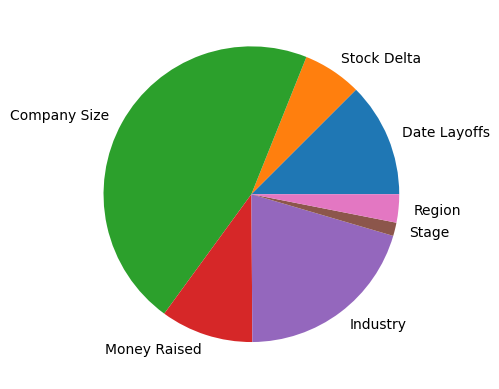

In [79]:
plt.pie(importances, labels=categories)

Figure above shows importance of each feature in prediction